### Clean and slim the repertoire files

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [35]:
# Set HLA of interest - change dynamically
hla = 'A*01'
hla_name = hla.replace('*','')

# Generate file names

os.chdir("/Users/ishaharris/Projects/TCR/TCR-Isha/data/Repertoires")

metadata = pd.read_csv("/Users/ishaharris/Projects/TCR/TCR-Isha/data/Repertoires/Cohort01_whole_metadata.tsv", sep="\t") 


metadata_annotat = metadata[metadata['sample_tags'].str.contains(f'HLA-{hla}',case=False, regex = False)]

metadata_annotat = metadata_annotat[metadata_annotat['sample_tags'].str.contains(r'\bcytomegalovirus|CMV\b', case=False, na=False)]
metadata_annotat = metadata_annotat.reset_index(drop=True)

#Extract pos and neg patient IDs
pos_names = metadata_annotat[metadata_annotat['sample_tags'].str.contains(r'\bcytomegalovirus \+|CMV \+\b', case=False, na=False)]
neg_names = metadata_annotat[metadata_annotat['sample_tags'].str.contains(r'\bcytomegalovirus -|CMV -\b', case=False, na=False)]

#Turn into file names
file_names = [name + '.tsv' for name in metadata_annotat['sample_name'].tolist()]
pos_names = [name + '.tsv' for name in pos_names['sample_name'].tolist()]
neg_names = [name + '.tsv' for name in neg_names['sample_name'].tolist()]


metadata_annotat.loc[10,'sample_tags']

print(f'Number of files with CMV and HLA annotation: {len(file_names)}')
print(f'Number of files with CMV +: {len(pos_names)}')
print(f'Number of files with CMV -: {len(neg_names)}')


Number of files with CMV and HLA annotation: 223
Number of files with CMV +: 98
Number of files with CMV -: 125


In [36]:
#!/usr/bin/env python3
import pandas as pd
from pathlib import Path

# === USER SETTINGS ===
INPUT_DIR    = Path("/Volumes/IshaVerbat/Isha/TCR/All_Emerson_Cohort01")      # your raw .tsv files
OUTPUT_DIR   = Path("/Volumes/IshaVerbat/Isha/TCR/Filtered_HLA-A01")    # where slim TSVs & metadata CSV will go
CHAIN        = "beta"                          # always "beta"
ID_COLUMN    = "sample_name"                   # the column that uniquely IDs each file/patient
DATA_COLUMNS = [
    "rearrangement",
    "amino_acid",           # CDR3 sequence
    "v_gene",               # V gene
    "d_gene",               # D gene
    "j_gene",               # J gene
    "frequency",            # clone freq
    "productive_frequency", # productive freq
]
METADATA_COLUMNS = [
    "total_templates",
    "productive_templates",
    "total_reads",
    "total_productive_reads",
    "fraction_productive"
    
    # add more if you need them
]
# =====================

print("📄 Found the following TSV files for processing:")

tsv_files = []

for fname in file_names:
    print(f" Checking file: {fname}")
    
    if not fname.endswith(".tsv"):
        print(f" Skipped (not .tsv): {fname}")
        continue
    if fname.startswith(".") or fname.startswith("._"):
        print(f" Skipped (hidden or Apple metadata): {fname}")
        continue

    full_path = INPUT_DIR / fname
    print(f"  ✅ Accepted: {full_path}")
    tsv_files.append(full_path)


print("Processing the following TSV files")
for f in tsv_files:
    print(f"  {f.name}")
print(f"\n{len(tsv_files)} files found in {INPUT_DIR}.")

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
meta_csv = OUTPUT_DIR / "tcrdist_combined_metadata.csv"

# Load any existing metadata so we can append new rows
if meta_csv.exists():
    metadata_df = pd.read_csv(meta_csv, index_col=ID_COLUMN)
    completed_ids = set(metadata_df.index)
else:
    metadata_df = pd.DataFrame(
        columns=METADATA_COLUMNS,
    )
    metadata_df.index.name = ID_COLUMN
    completed_ids = set()

# How to rename columns for tcrdist3 β-chain
rename_map = {
    "amino_acid":           "cdr3_b_aa",
    "v_gene":               "v_b_gene",
    "j_gene":               "j_b_gene",
    # d_gene, frequency, productive_frequency stay unchanged
}

# Process files one by one
for idx, in_path in enumerate(tsv_files, start=1):
    print(f"\n[{idx}/{len(tsv_files)}] Processing {in_path.name}...")
    
    # Read just the sample ID first to check if we’ve already processed this
    try:
        sample_id = pd.read_csv(in_path, sep="\t", usecols=[ID_COLUMN], nrows=1)[ID_COLUMN][0]
    except Exception as e:
        print(f"Could not read sample ID from {in_path.name}: {e}")
        continue

    if sample_id in completed_ids:
        print(f"Skipping {in_path.name} (already processed)")
        continue

    try:
        # Load only relevant columns
        usecols = [ID_COLUMN] + DATA_COLUMNS + METADATA_COLUMNS
        df = pd.read_csv(in_path, sep="\t", usecols=usecols, dtype=str, low_memory=False)
        print(f'Read {df.shape[0]} rows and {df.shape[1]} columns from {in_path.name}')

        # Extract metadata
        meta = {ID_COLUMN: sample_id}
        for col in METADATA_COLUMNS:
            meta[col] = df[col].iat[0] if df[col].nunique(dropna=False) == 1 else df[col].iat[0]
            df.drop(columns=col, inplace=True)

        # Remove sample ID from table and store metadata
        df.drop(columns=[ID_COLUMN], inplace=True)
        df.rename(columns=rename_map, inplace=True)
        df["frequency"] = df["frequency"].astype(float)
        df["productive_frequency"] = df["productive_frequency"].astype(float)

        # Save slimmed TSV
        out_tsv = OUTPUT_DIR / in_path.name.replace(".tsv", ".slim.tsv")
        df.to_csv(out_tsv, sep="\t", index=False)

        # Append metadata
        metadata_df.loc[sample_id] = meta
        metadata_df.to_csv(meta_csv)
        print(f"📝 Processed {in_path.name} → {out_tsv.name}")

    except Exception as e:
        print(f"Error processing {in_path.name}: {e}")
        continue

print(f"\n Done. Slim files and combined metadata written to: {OUTPUT_DIR}")


📄 Found the following TSV files for processing:
 Checking file: P00404.tsv
  ✅ Accepted: /Volumes/IshaVerbat/Isha/TCR/All_Emerson_Cohort01/P00404.tsv
 Checking file: P00416.tsv
  ✅ Accepted: /Volumes/IshaVerbat/Isha/TCR/All_Emerson_Cohort01/P00416.tsv
 Checking file: P00037.tsv
  ✅ Accepted: /Volumes/IshaVerbat/Isha/TCR/All_Emerson_Cohort01/P00037.tsv
 Checking file: P00346.tsv
  ✅ Accepted: /Volumes/IshaVerbat/Isha/TCR/All_Emerson_Cohort01/P00346.tsv
 Checking file: P00278.tsv
  ✅ Accepted: /Volumes/IshaVerbat/Isha/TCR/All_Emerson_Cohort01/P00278.tsv
 Checking file: P00260.tsv
  ✅ Accepted: /Volumes/IshaVerbat/Isha/TCR/All_Emerson_Cohort01/P00260.tsv
 Checking file: P00210.tsv
  ✅ Accepted: /Volumes/IshaVerbat/Isha/TCR/All_Emerson_Cohort01/P00210.tsv
 Checking file: P00208.tsv
  ✅ Accepted: /Volumes/IshaVerbat/Isha/TCR/All_Emerson_Cohort01/P00208.tsv
 Checking file: P00134.tsv
  ✅ Accepted: /Volumes/IshaVerbat/Isha/TCR/All_Emerson_Cohort01/P00134.tsv
 Checking file: P00088.tsv
  ✅ Acc

### Load in highconf

In [3]:
# Load high conf data

highconf_file_name = 'VDJ_INFO_AC02_high_conf_CMV_TCRs.csv'

highconf = pd.read_csv(f'/Users/ishaharris/Projects/TCR/TCR-Isha/data/High_Confidence_CMV_TCR/{highconf_file_name}')

highconf

# ------------------ COMMENTED OUT BECAUSE VDJ INFO FILES HAVE AMINO_ACID == ONLY TRB --------------------
# Add a column with just the TRB sequence 

# highconf_trb = highconf.loc[:, 'cdr3s_aa']
# highconf_trb=highconf_trb.apply(lambda x: re.search(r'TRB:([^;]+)', x).group(1) if 'TRB:' in x else None)
# len(highconf_trb)

# highconf['TRB'] = highconf_trb



,clonotype_id,amino_acid,count,v_call,d_call,j_call
0,AC02_clonotype9,CASSPYTGTGYGYTF,110.0,TRBV6-5,NaN,TRBJ1-2
1,AC02_clonotype9,CASSPYTGTGYGYTF,85.0,TRBV6-5,NaN,TRBJ1-2
2,AC02_clonotype1,CASSSVNEQFF,74.0,TRBV12-4,NaN,TRBJ2-1
3,AC02_clonotype1,CASSSVNEQFF,71.0,TRBV12-4,NaN,TRBJ2-1
4,AC02_clonotype5,CASSSVNEQFF,44.0,TRBV12-4,NaN,TRBJ2-1
...,...,...,...,...,...,...
4121,AC02_clonotype27,CASSPYTGTGYGYTF,184.0,TRBV6-5,NaN,TRBJ1-2
4122,AC02_clonotype1,CASSSVNEQFF,31.0,TRBV12-4,NaN,TRBJ2-1
4123,AC02_clonotype8,CASSSVNEQFF,52.0,TRBV12-4,NaN,TRBJ2-1
4124,AC02_clonotype8,CASSSVNEQFF,48.0,TRBV12-4,NaN,TRBJ2-1


In [34]:
# Load a sample repertoire
rep = pd.read_csv('/Volumes/IshaVerbat/Isha/TCR/filtered_for_tcrdist/P00021.slim.tsv', sep="\t")

# count 
rep

,rearrangement,cdr3_b_aa,frequency,productive_frequency,v_b_gene,d_gene,j_b_gene
0,GCCTTGTTGCTGGGGGACTCGGCCCTGTATCTCTGTGCCAGCAGCC...,CASSPRGARSLETQYF,8.532311e-07,0.000001,TCRBV05-05,unresolved,TCRBJ02-05
1,AACGCCTTGTTGCTGGGGGACTCGGCCCTGTATCTCTGTGCCAGCA...,CASSPGTGAWQPQHF,1.023877e-06,0.000001,TCRBV05-05,TCRBD01-01,TCRBJ01-05
2,CTGAATGTGAACGCCTTGTTGCTGGGGGACTCGGCCCTGTATCTCT...,CASSRDGYGYTF,1.023877e-06,0.000001,TCRBV05-05,unresolved,TCRBJ01-02
3,GTTGCTGGGGGACTCGGCCCTGTATCTCTGTGCCAGCAGCTGGGGG...,NaN,1.023877e-06,NaN,TCRBV05-05,TCRBD02-01,TCRBJ01-05
4,AATGTGAACGCCTTGTTGCTGGGGGACTCGGCCCTGTATCTCTGTG...,CASSLYTNTEAFF,1.194524e-06,0.000001,TCRBV05-05,TCRBD01-01,TCRBJ01-01
...,...,...,...,...,...,...,...
187249,CTGAAGATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCT...,CASSSSAREQYF,1.692811e-04,0.000202,unresolved,TCRBD02-01,TCRBJ02-07
187250,GTGACCAGTGCCCATCCTGAAGACAGCAGCTTCTACATCTGCAGGG...,CRAR*QSSGNTIYF,2.214988e-04,NaN,unresolved,TCRBD01-01,TCRBJ01-03
187251,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCA...,CASSLGGTLNTEAFF,2.517032e-04,0.000300,unresolved,unresolved,TCRBJ01-01
187252,TAGAGTCTGCCATCCCCAACCAGACAGCTCTTTACTTCTGTGCCAC...,NaN,3.288353e-04,NaN,unresolved,TCRBD01-01,TCRBJ01-02


### Try to fix v gene naming

For v gene

In [4]:
db_dir = '/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/db'
db_file = 'alphabeta_gammadelta_db.tsv'

# Load the database
db = pd.read_csv(f'{db_dir}/{db_file}', sep="\t")

# find rows starting with TRB27
trb_v = db[db['id'].str.startswith('TRBV')]
# turn into a list of ids
trb_v_list = trb_v['id'].tolist()

# Get a list of all id that don't have a hyphen in it
trb_v_no_hyphen = trb_v[~trb_v['id'].str.contains('-')]
trb_v_no_hyphen_list = trb_v_no_hyphen['id'].tolist()
v_no_hyphen_numbers = [re.search(r'TRBV(\d+)', item).group(1) for item in trb_v_no_hyphen_list]
print(f'No hyphen numbers:{v_no_hyphen_numbers}')


# Get a list of all id that have a hyphen in it
trb_v_hyphen = trb_v[trb_v['id'].str.contains('-')]
trb_v_hyphen_list = trb_v_hyphen['id'].tolist()
trb_v_hyphen_list
v_hyphen_numbers = [re.search(r'TRBV(\d+)', item).group(1) for item in trb_v_hyphen_list]
print(f'Hyphen numbers:{v_hyphen_numbers}')


trb_v_no_hyphen_list
trb_v_hyphen_list

# ccheck if a number is in the list
number = '1'
if number in v_no_hyphen_numbers:
    print(f'{number} is in the list')


# Save to pickes
import pickle
import os

directory = '/Users/ishaharris/Projects/TCR/TCR-Isha/data/tcrdist/pickles'

# Make sure the directory exists
os.makedirs(directory, exist_ok=True)



# save trb_v_no_hyphen_list to picke
with open(f'{directory}/trb_v_no_hyphen_list.pkl', 'wb') as f:
    pickle.dump(trb_v_no_hyphen_list, f)

with open(f'{directory}/trb_v_hyphen_list.pkl', 'wb') as f:
    pickle.dump(trb_v_hyphen_list, f)
with open(f'{directory}/v_no_hyphen_numbers.pkl', 'wb') as f:
    pickle.dump(v_no_hyphen_numbers, f)
with open(f'{directory}/v_hyphen_numbers.pkl', 'wb') as f:
    pickle.dump(v_hyphen_numbers, f)

No hyphen numbers:['1', '1', '10', '14', '15', '16', '16', '16', '16', '17', '19', '19', '19', '2', '20', '20', '21', '23', '24', '24', '24', '24', '26', '26', '29', '29', '3', '3', '30', '31', '31', '4', '4', '5', '5', '5', '5', '5', '8', '9', '1', '13', '13', '14', '14', '15', '15', '15', '16', '16', '16', '17', '18', '19', '19', '19', '2', '2', '2', '26', '27', '28', '30', '30', '30', '30', '9', '9', '9']
Hyphen numbers:['12', '12', '12', '12', '13', '13', '13', '13', '13', '13', '13', '13', '10', '10', '10', '10', '10', '10', '10', '10', '11', '11', '11', '11', '11', '11', '11', '12', '12', '12', '12', '12', '12', '20', '20', '20', '20', '20', '20', '20', '20', '20', '20', '21', '21', '23', '23', '23', '24', '24', '25', '26', '26', '29', '29', '29', '29', '29', '3', '3', '3', '3', '3', '4', '4', '4', '4', '4', '4', '4', '4', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '7', '7', '7',

In [43]:
# db id cols starging with TRBV7
trb_v7 = db[db['id'].str.startswith('TRBV7')]
trb_v7

,id,organism,chain,region,nucseq,frame,aligned_protseq,cdr_columns,cdrs
679,TRBV7-1*01,human,B,V,ggtgctggagtctcccagtccctgagacacaaggtagcaaagaagg...,1,GAGVSQSLRHKVAKKGKDVALRYDPISGH.......NALYWYRQSL...,27-38;56-65;81-86;104-109,SGH.......NA;FQG....KDA;S.EGSI;CASSS.
680,TRBV7-2*01,human,B,V,ggagctggagtctcccagtcccccagtaacaaggtcacagagaagg...,1,GAGVSQSPSNKVTEKGKDVELRCDPISGH.......TALYWYRQSL...,27-38;56-65;81-86;104-109,SGH.......TA;FQG....NSA;T.GGSV;CASSL.
681,TRBV7-2*02,human,B,V,ggagctggagtctcccagtcccccagtaacaaggtcacagagaagg...,1,GAGVSQSPSNKVTEKGKDVELRCDPISGH.......TALYWYRQRL...,27-38;56-65;81-86;104-109,SGH.......TA;FQG....NSA;T.GESV;CASSL.
682,TRBV7-2*03,human,B,V,ggagctggagtctcccagtcccccagtaacaaggtcacagagaagg...,1,GAGVSQSPSNKVTEKGKDVELRCDPISGH.......TALYWYRQRL...,27-38;56-65;81-86;104-109,SGH.......TA;FQG....NSA;T.GESV;CTSSL.
683,TRBV7-2*04,human,B,V,ggagctggagtttcccagtcccccagtaacaaggtcacagagaagg...,1,GAGVSQSPSNKVTEKGKDVELRCDPISGH.......TALYWYRQSL...,27-38;56-65;81-86;104-109,SGH.......TA;FQG....NSA;T.GGSV;CASSL.
684,TRBV7-3*01,human,B,V,ggtgctggagtctcccagacccccagtaacaaggtcacagagaagg...,1,GAGVSQTPSNKVTEKGKYVELRCDPISGH.......TALYWYRQSL...,27-38;56-65;81-86;104-109,SGH.......TA;FQG....TGA;P.EGSV;CASSL.
685,TRBV7-3*02,human,B,V,ggtgctggagtctcccagacccccagtaacaaggtcacagagaagg...,1,GAGVSQTPSNKVTEKGKDVELRCDPISGH.......TALYWYRQSL...,27-38;56-65;81-86;104-109,SGH.......TA;FQG....TGA;P.EGSV;RASSL.
686,TRBV7-3*03,human,B,V,ggtgctggagtctcccagacccccagtaacaaggtcacagagaagg...,1,GAGVSQTPSNKVTEKGKDVELRCDPISGH.......TALYWYRQSL...,27-38;56-65;81-86;104-109,SGH.......TA;FQG....TGA;P.EGSV;RASSL.
687,TRBV7-3*04,human,B,V,ggtgctggagtctcccagacccccagtaacaaggtcacagagaagg...,1,GAGVSQTPSNKVTEKGKYVELRCDPISGH.......TALYWYRQSL...,27-38;56-65;81-86;104-109,SGH.......TA;FQG....TGA;P.EGSV;CASS..
688,TRBV7-3*05,human,B,V,tgggagctcaggtgtgatccaatttcaggtcatactgccctttact...,1,..................WELRCDPISGH.......TALYWYRQSL...,27-38;56-65;81-86;104-109,SGH.......TA;FQG....TGA;P.EGSV;CASS..


For J gene

In [5]:
import pandas as pd
import re

db_dir = '/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/db'
db_file = 'alphabeta_gammadelta_db.tsv'

# Load the database
db = pd.read_csv(f'{db_dir}/{db_file}', sep="\t")

# Find rows starting with TRBJ
trb_j = db[db['id'].str.startswith('TRBJ')]

# Turn into a list of ids
trb_j_list = trb_j['id'].tolist()

# Get a list of all ids that don't have a hyphen in them
trb_j_no_hyphen = trb_j[~trb_j['id'].str.contains('-')]
trb_j_no_hyphen_list = trb_j_no_hyphen['id'].tolist()
j_no_hyphen_numbers = [re.search(r'TRBJ(\d+)', item).group(1) for item in trb_j_no_hyphen_list]
print(f'No hyphen numbers: {j_no_hyphen_numbers}')

# Get a list of all ids that do have a hyphen in them
trb_j_hyphen = trb_j[trb_j['id'].str.contains('-')]
trb_j_hyphen_list = trb_j_hyphen['id'].tolist()
j_hyphen_numbers = [re.search(r'TRBJ(\d+)', item).group(1) for item in trb_j_hyphen_list]
print(f'Hyphen numbers: {j_hyphen_numbers}')

# Example: check if a number is in the no-hyphen list
number = '2'
if number in j_no_hyphen_numbers:
    print(f'{number} is in the no-hyphen list')


# Save to pickle
import pickle
import os

directory = '/Users/ishaharris/Projects/TCR/TCR-Isha/data/tcrdist/pickles'

# Make sure the directory exists
os.makedirs(directory, exist_ok=True)



with open(f'{directory}/trb_j_no_hyphen_list.pkl', 'wb') as f:
    pickle.dump(trb_v_no_hyphen_list, f)
with open(f'{directory}/trb_j_hyphen_list.pkl', 'wb') as f:
    pickle.dump(trb_v_hyphen_list, f)
with open(f'{directory}/j_no_hyphen_numbers.pkl', 'wb') as f:
    pickle.dump(v_no_hyphen_numbers, f)
with open(f'{directory}/j_hyphen_numbers.pkl', 'wb') as f:
    pickle.dump(v_hyphen_numbers, f)


No hyphen numbers: []
Hyphen numbers: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2']


In [18]:
trb_v_list

['TRBV1*01',
 'TRBV1*02',
 'TRBV10*01',
 'TRBV12-1*01',
 'TRBV12-1*02',
 'TRBV12-2*01',
 'TRBV12-2*02',
 'TRBV13-1*01',
 'TRBV13-1*02',
 'TRBV13-2*01',
 'TRBV13-2*02',
 'TRBV13-2*03',
 'TRBV13-2*04',
 'TRBV13-2*05',
 'TRBV13-3*01',
 'TRBV14*01',
 'TRBV15*01',
 'TRBV16*01',
 'TRBV16*02',
 'TRBV16*03',
 'TRBV16*04',
 'TRBV17*01',
 'TRBV19*01',
 'TRBV19*02',
 'TRBV19*03',
 'TRBV2*01',
 'TRBV20*01',
 'TRBV20*02',
 'TRBV21*01',
 'TRBV23*01',
 'TRBV24*01',
 'TRBV24*02',
 'TRBV24*03',
 'TRBV24*04',
 'TRBV26*01',
 'TRBV26*02',
 'TRBV29*01',
 'TRBV29*02',
 'TRBV3*01',
 'TRBV3*02',
 'TRBV30*01',
 'TRBV31*01',
 'TRBV31*02',
 'TRBV4*01',
 'TRBV4*02',
 'TRBV5*01',
 'TRBV5*02',
 'TRBV5*03',
 'TRBV5*04',
 'TRBV5*05',
 'TRBV8*01',
 'TRBV9*01',
 'TRBV1*01',
 'TRBV10-1*01',
 'TRBV10-1*02',
 'TRBV10-2*01',
 'TRBV10-2*02',
 'TRBV10-3*01',
 'TRBV10-3*02',
 'TRBV10-3*03',
 'TRBV10-3*04',
 'TRBV11-1*01',
 'TRBV11-2*01',
 'TRBV11-2*02',
 'TRBV11-2*03',
 'TRBV11-3*01',
 'TRBV11-3*02',
 'TRBV11-3*03',
 'TRBV12-

### Write TCRdist calculator

##### Ignore this below

In [ ]:
#!/usr/bin/env python
"""
Compute TCRdist between a panel of high‑confidence CMV‑associated TRB clonotypes and each patient's bulk TCRB repertoire.
The script mirrors the logic of the previous Levenshtein implementation but leverages **tcrdist3** for a biochemically‑weighted distance.

Dependencies
------------
    pip install tcrdist3 pandas numpy

Input
-----
* A TSV (or CSV) file containing the CMV‑associated search set (≈200 rows).
* A directory of TSV/CSV files – one per patient – already filtered to unique productive TRB clonotypes (≈3×10⁵ rows each).

Both inputs must expose **cdr3_b_aa**, **v_b_gene**, **j_b_gene** columns (see `prepare_df`).

Output
------
`tcrdist_output.csv` – One row per patient with a histogram of TCRdist values (0‥MAX_DIST).

Notes
-----
* The tcrdist scale is *not* the same as edit distance. A single amino‑acid substitution in CDR3 is ≈ 12 distance units when TRBV and TRBJ genes match. A radius of 36 therefore captures most functional "one‑to‑two‑sub" neighbours (Dash et al., 2017).
* The computation is executed as a sparse **rectangular** distance matrix; only distances ≤ `RADIUS` are kept in memory.
* Adapt `MAX_DIST`, `RADIUS`, and path variables as needed.
"""

import os
import re
import multiprocessing
import numpy as np
import pandas as pd
from tcrdist.repertoire import TCRrep
from tcrdist.breadth import get_safe_chunk

excluded_genes = []

print(' - Loaded libraries.')

# ──────────────────────────────────────────────────────────────────────────────
# User‑configurable parameters
# ──────────────────────────────────────────────────────────────────────────────
HLA = 'A02'
MAX_DIST   = 50        # highest TCRdist bucket to tally (inclusive)
RADIUS     = MAX_DIST  # distances > RADIUS are discarded by tcrdist3
HIGHCONF   = highconf   # search‑set file
PATIENT_DIR = f"/Volumes/IshaVerbat/Isha/TCR/Filtered_HLA-{HLA}"  # directory with patient files
OUTFILE    = "tcrdist_output_freqs.csv"
N_CPUS     = min(multiprocessing.cpu_count(), 8)

# set wd
os.chdir("/Users/ishaharris/Projects/TCR/TCR-Isha/data/tcrdist")

MAX_FILES = 4

print(' - Set parameters.')

# ──────────────────────────────────────────────────────────────────────────────
# Helper functions
# ──────────────────────────────────────────────────────────────────────────────
GENE_PAT = re.compile(r"[*!].*$")


def _normalize_gene(s: str) -> str:
    """Strip prefixes / allele info to IMGT-like gene names understood by tcrdist3,
    remove leading zeros from gene numbers (e.g. TRBV05 → TRBV5),
    and from any numeric subfields (e.g. TRBV5-05 → TRBV5-5)."""
    if pd.isna(s):
        return np.nan
    # Standardize prefix
    s = str(s).replace("TCR", "TR")  # e.g. TCRBV05-05 → TRBV05-05

    # Remove leading zeros from primary gene number (e.g. TRBV05 → TRBV5)
    s = re.sub(
        r"^([A-Z]+)(0+)(\d+)",
        lambda m: f"{m.group(1)}{int(m.group(2) + m.group(3))}",
        s,
    )

    # Remove leading zeros from any subfield after hyphens (e.g. -05 → -5)
    s = re.sub(
        r"-(0+)(\d+)",
        lambda m: f"-{int(m.group(1) + m.group(2))}",
        s,
    )

    # Normalize allele information to *01
    if "*" in s:
        s = re.sub(r"[*!].*$", "*01", s)
    else:
        s = s + "*01"

    # Fix adaptive errors in V gene names - they added in -01 for families with only one gene. 
    # Get the number from the string

    if not re.match(r'^TRB[JV]\d+(-\d+)?\*\d+$', s):
        excluded_genes.append(s)
        print(f"Excluded malformed gene: {s}")
        return np.nan

    number = re.search(r'TRB[JV](\d+)', s).group(1)

    if number in no_hyphen_numbers and s not in trb_v_list:
        print(f'{s}: no match')
        s = re.sub(r'-\d+(?=\*)', '', s)
        print(f'Changed to {s}')

    return s


def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
    """Bring an arbitrary clonotype table to tcrdist3‑ready shape."""
    # Remove d_gene column
    if "d_gene" in df.columns:
        df = df.drop(columns=["d_gene"])
    
    rename_map = {
        "amino_acid": "cdr3_b_aa",
        "cdr3s_aa": "cdr3_b_aa",
        "v_call": "v_b_gene",
        "j_call": "j_b_gene",
    }

    df = df.rename(columns=rename_map)

    has_freq = "productive_frequency" in df.columns

    base_cols = ["cdr3_b_aa", "v_b_gene", "j_b_gene"]
    use_cols = base_cols + (['productive_frequency'] if has_freq else [])

    df["v_b_gene"] = df["v_b_gene"].apply(_normalize_gene)
    df["j_b_gene"] = df["j_b_gene"].apply(_normalize_gene)
  

    df = df.drop_duplicates().reset_index(drop=True)

    # if the same CDR3/v_gene/j_gene appears multiple times, sum its frequencies
    df = (
        df.groupby(["cdr3_b_aa", "v_b_gene", "j_b_gene"], as_index=False)
        .agg({"productive_frequency": "sum"})
    )
    return df

print('Defined functions.')

# ──────────────────────────────────────────────────────────────────────────────
# Load the CMV‑associated search set once
# ──────────────────────────────────────────────────────────────────────────────
print("Loading high‑confidence CMV search set …")
high_raw  = highconf
high_df   = prepare_df(high_raw)
print(high_df.head())

print(f" → {len(high_df):,} unique TRB clonotypes ready for search.")

tr_search = TCRrep(cell_df=high_df, organism="human", chains=["beta"], compute_distances=False)

tr_search.cpus = N_CPUS

# ──────────────────────────────────────────────────────────────────────────────
# Prepare output buffer and file names
# ──────────────────────────────────────────────────────────────────────────────

results_buffer = []
outfile = OUTFILE

file_names = sorted(fn for fn in os.listdir(PATIENT_DIR) if fn.endswith(('.tsv', '.csv')) and fn.startswith('P'))

# cols = ["patient_id"] + [f"dist_{d}" for d in range(MAX_DIST + 1)]
# results = pd.DataFrame(columns=cols)

# ──────────────────────────────────────────────────────────────────────────────
# Main loop over patient repertoires
# ──────────────────────────────────────────────────────────────────────────────
file_names = sorted(fn for fn in os.listdir(PATIENT_DIR) if fn.endswith(('.tsv', '.csv')) and fn.startswith('P'))

for idx, fname in enumerate(file_names, 1):
    if idx > MAX_FILES:
        print(f"Reached maximum number of files to process ({MAX_FILES}).")
        break
    patient_id = os.path.splitext(fname)[0]
    print(f"Processing ({idx}/{len(file_names)}): {patient_id}")

    # Load & clean bulk repertoire
    rep_raw = pd.read_csv(os.path.join(PATIENT_DIR, fname), sep="\t", low_memory=False)
    rep_df  = prepare_df(rep_raw)

    if rep_df.empty:
        print(f" ! No usable sequences in {patient_id} – skipping.")
        continue

    # extract and sum productive frequencies
    rep_freq = rep_raw.rename(columns = {
        "amino_acid": "cdr3_b_aa",
        'cdr3s_aa': "cdr3_b_aa",
        "v_call": "v_b_gene",
        "j_call": "j_b_gene",
    })

    # keep rows with required fields
    rep_freq = rep_freq[["cdr3_b_aa", "v_b_gene", "j_b_gene", "productive_frequency"]].dropna()

    # normalise gene names
    rep_freq["v_b_gene"] = rep_freq["v_b_gene"].apply(_normalize_gene)
    rep_freq["j_b_gene"] = rep_freq["j_b_gene"].apply(_normalize_gene)

    # sum productive frequencies for each unique clono
    rep_freq = (
        rep_freq.groupby(["cdr3_b_aa", "v_b_gene", "j_b_gene"], as_index=False)
        .agg({"productive_frequency": "sum"})
    )

    # merge back into cleaned core
    rep_df = pd.merge(rep_core, rep_freq, on=["cdr3_b_aa", "v_b_gene", "j_b_gene"], how="left").fillna({'productive_frequency': 0})


    tr_bulk = TCRrep(cell_df=rep_df, organism="human", chains=["beta"], compute_distances=False)



    # Compute sparse rectangular distances (rows=search, cols=bulk)
    chunk_size = get_safe_chunk(tr_search.clone_df.shape[0], tr_bulk.clone_df.shape[0])
    tr_search.compute_sparse_rect_distances(
        df=tr_search.clone_df,
        df2=tr_bulk.clone_df,
        radius=RADIUS,
        chunk_size=chunk_size,
    )

    # Histogram distances ≤ RADIUS
    coo = tr_search.rw_beta.tocoo()
    dists = coo.data.astype(int)
    cols = coo.col
    freqs = tr_bulk.clone_df['productive_frequency'].values

    bins = np.zeros(MAX_DIST + 1, dtype=float)
    np.add.at(bins, dists, freqs[cols])

    # Append to results
    row = {"patient_id": patient_id, **{f"dist_{d}": bins[d] for d in range(MAX_DIST + 1)}}
    results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

    # Persist after each patient
    results.to_csv(OUTFILE, index=False)
    print(f"   ↳ saved ➜ {OUTFILE}")

    # Free distance matrix to keep RAM stable before next iteration
    del tr_search.rw_beta

print("✔︎ All patient repertoires processed.")


 - Loaded libraries.
 - Set parameters.
Defined functions.
Loading high‑confidence CMV search set …


KeyError: "Column(s) ['productive_frequency'] do not exist"

### Tester area

In [91]:
tr_search = TCRrep(cell_df=high_df, organism="human", chains=["beta"], compute_distances=False)
tr_search.compute_distances()
print("clone_df shape:", tr_search.clone_df.shape)  # should be ≈ 200


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:165: UserWarning: db_file must be 'alphabeta_gammadelta_db.tsv' or 'alphabeta_db.tsv' or 'gammadelta_db.tsv' unless you have built tcrdist3 from scratch
  self._validate_db_file()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:500: UserWarning: TRBV6-5 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:500: UserWarning: TRBV12-4 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:500: UserWarning: TRBV12-5 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v

ValueError: zero-size array to reduction operation maximum which has no identity

In [30]:
import numpy as np

bins  = np.zeros(5, dtype=int)
freqs = np.array([0.1, 0.3, 0.6])
# pretend we saw one of each at distance 0,1,2
np.add.at(bins, [0,1,2], freqs)
print(bins)   # → [0 0 0 0 0]


[0 0 0 0 0]


##### Original raw counts

In [ ]:

#!/usr/bin/env python
"""
Compute TCRdist between a panel of high‑confidence CMV‑associated TRB clonotypes and each patient's bulk TCRB repertoire.
The script mirrors the logic of the previous Levenshtein implementation but leverages **tcrdist3** for a biochemically‑weighted distance.

## Dependencies

```
pip install tcrdist3 pandas numpy
```

## Input

* A TSV (or CSV) file containing the CMV‑associated search set (≈200 rows).
* A directory of TSV/CSV files – one per patient – already filtered to unique productive TRB clonotypes (≈3×10⁵ rows each).

Both inputs must expose **cdr3\_b\_aa**, **v\_b\_gene**, **j\_b\_gene** columns (see `prepare_df`).

## Output

`tcrdist_output.csv` – One row per patient with a histogram of TCRdist values (0‥MAX\_DIST).

## Notes

* The tcrdist scale is *not* the same as edit distance. A single amino‑acid substitution in CDR3 is ≈ 12 distance units when TRBV and TRBJ genes match. A radius of 36 therefore captures most functional "one‑to‑two‑sub" neighbours (Dash et al., 2017).
* The computation is executed as a sparse **rectangular** distance matrix; only distances ≤ `RADIUS` are kept in memory.
* Adapt `MAX_DIST`, `RADIUS`, and path variables as needed.
  """

import os
import re
import multiprocessing
import numpy as np
import pandas as pd
from tcrdist.repertoire import TCRrep
from tcrdist.breadth import get_safe_chunk

excluded_genes = []

print(' - Loaded libraries.')

# ──────────────────────────────────────────────────────────────────────────────

# User‑configurable parameters

# ──────────────────────────────────────────────────────────────────────────────

MAX_DIST   = 50        # highest TCRdist bucket to tally (inclusive)
RADIUS     = MAX_DIST  #distances > RADIUS are discarded by tcrdist3
HIGHCONF   = highconf   # search‑set file
PATIENT_DIR = "/Volumes/IshaVerbat/Isha/TCR/filtered\_for\_tcrdist"  # directory with patient files
OUTFILE    = "tcrdist\_output.csv"
N_CPUS     = min(multiprocessing.cpu_count(), 8)

# set wd

os.chdir("/Users/ishaharris/Projects/TCR/TCR-Isha/data/tcrdist")

MAX_FILES = 4

print(' - Set parameters.')

# ──────────────────────────────────────────────────────────────────────────────

# Helper functions

# ──────────────────────────────────────────────────────────────────────────────

GENE_PAT = re.compile(r"\[*!].*\$")

def _normalize_gene(s: str) -> str:

 """ Strip prefixes / allele info to IMGT-like gene names understood by tcrdist3,
remove leading zeros from gene numbers (e.g. TRBV05 → TRBV5),
and from any numeric subfields (e.g. TRBV5-05 → TRBV5-5) """

if pd.isna(s):
return np.nan

```
print(f'Processing: {s}')
# Standardize prefix
s = str(s).replace("TCR", "TR")  # e.g. TCRBV05-05 → TRBV05-05

# Remove leading zeros from primary gene number (e.g. TRBV05 → TRBV5)
s = re.sub(
    r"^([A-Z]+)(0+)(\d+)",
    lambda m: f"{m.group(1)}{int(m.group(2) + m.group(3))}",
    s,
)

# Remove leading zeros from any subfield after hyphens (e.g. -05 → -5)
s = re.sub(
    r"-(0+)(\d+)",
    lambda m: f"-{int(m.group(1) + m.group(2))}",
    s,
)

# Normalize allele information to *01
if "*" in s:
    s = re.sub(r"[*!].*$", "*01", s)
else:
    s = s + "*01"

# Fix adaptive errors in V gene names - they added in -01 for families with only one gene. 
# Get the number from the string

if not re.match(r'^TRB[JV]\d+(-\d+)?\*\d+$', s):
    excluded_genes.append(s)
    print(f"Excluded malformed gene: {s}")
    return np.nan

number = re.search(r'TRB[JV](\d+)', s).group(1)

if number in no_hyphen_numbers and s not in trb_v_list:
    print(f'{s}: no match')
    s = re.sub(r'-\d+(?=\*)', '', s)
    print(f'Changed to {s}')

return s
```

def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
"""Bring an arbitrary clonotype table to tcrdist3‑ready shape."""
# Remove d\_gene column
if "d_gene" in df.columns:
df.drop(columns=["d_gene"], inplace=True)

```
rename_map = {
    "amino_acid": "cdr3_b_aa",
    "cdr3s_aa": "cdr3_b_aa",
    "v_call": "v_b_gene",
    "j_call": "j_b_gene",
}

df = df.rename(columns=rename_map)
need = ["cdr3_b_aa", "v_b_gene", "j_b_gene"]
df = df[need].copy()
df.dropna(inplace=True)

df["v_b_gene"] = df["v_b_gene"].apply(_normalize_gene)
df["j_b_gene"] = df["j_b_gene"].apply(_normalize_gene)


df = df.drop_duplicates().reset_index(drop=True)
return df


print('Defined functions.')

# ──────────────────────────────────────────────────────────────────────────────

# Load the CMV‑associated search set once

# ──────────────────────────────────────────────────────────────────────────────

print("Loading high‑confidence CMV search set …")
high_raw  = highconf
high_df   = prepare_df(high_raw)
print(high_df.head())

print(f" → {len(high_df):,} unique TRB clonotypes ready for search.")

tr_search = TCRrep(cell_df=high_df, organism="human", chains=["beta"], compute_distances=False)

tr_search.cpus = N_CPUS

# ──────────────────────────────────────────────────────────────────────────────

# Prepare output frame – one row per patient

# ──────────────────────────────────────────────────────────────────────────────

cols = ["patient_id"] + [f"dist_{d}" for d in range(MAX_DIST + 1)]
results = pd.DataFrame(columns=cols)

# ──────────────────────────────────────────────────────────────────────────────

# Main loop over patient repertoires

# ──────────────────────────────────────────────────────────────────────────────

file_names = sorted(fn for fn in os.listdir(PATIENT_DIR) if fn.endswith(('.tsv', '.csv')) and fn.startswith('P'))

for idx, fname in enumerate(file_names, 1):
if idx > MAX_FILES:
print(f"Reached maximum number of files to process ({MAX_FILES}).")
break
patient_id = os.path.splitext(fname)[0]
print(f"Processing ({idx}/{len(file_names)}): {patient_id}")

```
# Load & clean bulk repertoire
rep_raw = pd.read_csv(os.path.join(PATIENT_DIR, fname), sep="\t", low_memory=False)
rep_df  = prepare_df(rep_raw)

if rep_df.empty:
    print(f" ! No usable sequences in {patient_id} – skipping.")
    continue

tr_bulk = TCRrep(cell_df=rep_df, organism="human", chains=["beta"], compute_distances=False)



# Compute sparse rectangular distances (rows=search, cols=bulk)
chunk_size = get_safe_chunk(tr_search.clone_df.shape[0], tr_bulk.clone_df.shape[0])
tr_search.compute_sparse_rect_distances(
    df=tr_search.clone_df,
    df2=tr_bulk.clone_df,
    radius=RADIUS,
    chunk_size=chunk_size,
)

# Histogram distances ≤ RADIUS
bins = np.zeros(MAX_DIST + 1, dtype=int)
for d in tr_search.rw_beta.data.astype(int):
    bins[d] += 1

# Append to results
row = {"patient_id": patient_id, **{f"dist_{d}": bins[d] for d in range(MAX_DIST + 1)}}
results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

# Persist after each patient
results.to_csv(OUTFILE, index=False)
print(f"   ↳ saved ➜ {OUTFILE}")

# Free distance matrix to keep RAM stable before next iteration
del tr_search.rw_beta
```

print("✔︎ All patient repertoires processed.")


### Edited to be freq. USE THIS IT WORKS (i think)

In [7]:
#!/usr/bin/env python
"""
Compute TCRdist between a panel of high-confidence CMV-associated TRB clonotypes and each patient's bulk TCRB repertoire.
Uses tcrdist3 for biochemically-weighted distances, and writes out one CSV every 10 patients.
"""

import os
import re
import multiprocessing
import numpy as np
import pandas as pd
from tcrdist.repertoire import TCRrep
from tcrdist.breadth import get_safe_chunk
import pickle


# ──────────────────────────────────────────────────────────────────────────────
# 0. IMPORT PICKLES 
# ──────────────────────────────────────────────────────────────────────────────

PICKLE_DIR = "/Users/ishaharris/Projects/TCR/TCR-Isha/data/tcrdist/pickles/"  # ← adjust to your actual directory

with open(f"{PICKLE_DIR}/trb_v_no_hyphen_list.pkl", "rb") as f:
    trb_v_no_hyphen_list = pickle.load(f)

with open(f"{PICKLE_DIR}/trb_v_hyphen_list.pkl", "rb") as f:
    trb_v_hyphen_list = pickle.load(f)

with open(f"{PICKLE_DIR}/j_no_hyphen_numbers.pkl", "rb") as f:
    j_no_hyphen_numbers = pickle.load(f)

with open(f"{PICKLE_DIR}/j_hyphen_numbers.pkl", "rb") as f:
    j_hyphen_numbers = pickle.load(f)

# ──────────────────────────────────────────────────────────────────────────────
# 1. CONSTANTS & CONFIGURATION
# ──────────────────────────────────────────────────────────────────────────────
MAX_DIST    = 50        # highest TCRdist bucket to tally (inclusive)
RADIUS      = MAX_DIST  # distances > RADIUS are discarded by tcrdist3
HIGHCONF    = highconf  # your preloaded DataFrame of CMV-associated clonotypes
PATIENT_DIR = "/Volumes/IshaVerbat/Isha/TCR/filtered_for_tcrdist"
OUTFILE     = "/Users/ishaharris/Projects/TCR/TCR-Isha/data/tcrdist/tcrdist_output_freqs.csv"
N_CPUS      = min(multiprocessing.cpu_count(), 8)
MAX_FILES   = 292       # for testing; remove or increase as needed

######## RESUMING AUTOMATICALLY 

# Load previously saved results if resuming
if os.path.exists(OUTFILE):
    saved_df = pd.read_csv(OUTFILE)
    processed_ids = set(saved_df['patient_id'])
    results_buffer = saved_df.to_dict('records')
    print(f"↪ Resuming from checkpoint — {len(processed_ids)} patients already processed.")
else:
    print('No checkpoint found, starting fresh.')
    processed_ids = set()
    results_buffer = []

# ──────────────────────────────────────────────────────────────────────────────
# 2. HELPER FUNCTIONS
# ──────────────────────────────────────────────────────────────────────────────
excluded_genes = []

def _normalize_gene(s: str) -> str:
    """Strip prefixes/allele info to IMGT-like gene names, remove leading zeros."""
    if pd.isna(s):
        return np.nan
    s = str(s).replace("TCR", "TR")
    # remove leading zeros in main and subfields
    # Remove leading zeros from primary gene number (e.g. TRBV05 → TRBV5)
    s = re.sub(
        r"^([A-Z]+)(0+)(\d+)",
        lambda m: f"{m.group(1)}{int(m.group(2) + m.group(3))}",
        s,
    )   

    s = re.sub(
        r"-(0+)(\d+)",
        lambda m: f"-{int(m.group(1) + m.group(2))}",
        s,
    )


    # normalize allele to *01
    if "*" in s:
        s = re.sub(r"[*!].*$", "*01", s)
    else:
        s = s + "*01"
    # validate final form
    if not re.match(r"^TRB[JV]\d+(-\d+)?\*\d+$", s):
        excluded_genes.append(s)
        return np.nan

    number = re.search(r'TRB[JV](\d+)', s).group(1)

    # check if gene starts with TRBJ or TRBV
    if s.startswith('TRBJ'):
        if number in j_no_hyphen_numbers and s not in trb_j_list:
           
            s = re.sub(r'-\d+(?=\*)', '', s)
            
    elif s.startswith('TRBV'):
        if number in v_no_hyphen_numbers and s not in trb_v_list:
            
            s = re.sub(r'-\d+(?=\*)', '', s)
            

    
    
    return s

def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
    """Bring any clonotype table to tcrdist3-ready shape."""
    df = df.copy()
    if "d_gene" in df.columns:
        df = df.drop(columns=["d_gene"])
    # rename alternate columns
    rename_map = {
        "amino_acid": "cdr3_b_aa",
        "cdr3s_aa":  "cdr3_b_aa",
        "v_call":    "v_b_gene",
        "j_call":    "j_b_gene",
    }
    df = df.rename(columns=rename_map)
    # detect frequency
    has_freq = "productive_frequency" in df.columns
    use_cols = ["cdr3_b_aa", "v_b_gene", "j_b_gene"] + (["productive_frequency"] if has_freq else [])
    df = df[use_cols].dropna(subset=["cdr3_b_aa", "v_b_gene", "j_b_gene"])
    if not has_freq:
        df["productive_frequency"] = 1
    # normalize gene names
    df["v_b_gene"] = df["v_b_gene"].apply(_normalize_gene)
    df["j_b_gene"] = df["j_b_gene"].apply(_normalize_gene)
    # drop any failed normalizations
    df = df.dropna(subset=["v_b_gene", "j_b_gene"]).reset_index(drop=True)
    # dedupe & aggregate frequencies
    df = df.groupby(
        ["cdr3_b_aa", "v_b_gene", "j_b_gene"],
        as_index=False
    ).agg({"productive_frequency": "sum"})
    return df

# ──────────────────────────────────────────────────────────────────────────────
# 3. LOAD CMV-ASSOCIATED SEARCH SET ONCE
# ──────────────────────────────────────────────────────────────────────────────
high_df = prepare_df(HIGHCONF)
tr_search = TCRrep(
    cell_df=high_df,
    organism="human",
    chains=["beta"],
    compute_distances=False
)
tr_search.cpus = N_CPUS

# ──────────────────────────────────────────────────────────────────────────────
# 4. PREPARE OUTPUT BUFFER & FILE LIST
# ──────────────────────────────────────────────────────────────────────────────
results_buffer = []
outfile = OUTFILE
file_names = sorted(
    fn for fn in os.listdir(PATIENT_DIR)
    if fn.endswith(('.tsv', '.csv')) and fn.startswith('P')
)

# ──────────────────────────────────────────────────────────────────────────────
# 5. MAIN LOOP OVER PATIENT REPERTOIRES
# ──────────────────────────────────────────────────────────────────────────────
for idx, fname in enumerate(file_names, 1):
    if idx > MAX_FILES:
        print(f"Reached maximum number of files to process ({MAX_FILES}).")
        break

    patient_id = os.path.splitext(fname)[0]
    print(f"Processing ({idx}/{len(file_names)}): {patient_id}")

    if patient_id in processed_ids: 
        print(f'↪ Already processed {patient_id} – skipping.')
        continue

    ## 5.1 Load & clean
    rep_raw = pd.read_csv(
        os.path.join(PATIENT_DIR, fname),
        sep="\t", low_memory=False
    )
    rep_df = prepare_df(rep_raw)
    if rep_df.empty:
        print(f" ! No usable sequences in {patient_id} – skipping.")
        continue

    ## 5.2 Build TCRrep for bulk
    tr_bulk = TCRrep(
        cell_df=rep_df,
        organism="human",
        chains=["beta"],
        compute_distances=False
    )
    tr_bulk.cpus = N_CPUS

    ## 5.3 Compute sparse distances
    chunk_size = get_safe_chunk(
        tr_search.clone_df.shape[0],
        tr_bulk.clone_df.shape[0]
    )
    tr_search.compute_sparse_rect_distances(
        df=tr_search.clone_df,
        df2=tr_bulk.clone_df,
        radius=RADIUS,
        chunk_size=chunk_size,
    )

    ## 5.4 Build histogram
    coo   = tr_search.rw_beta.tocoo()
    dists = coo.data.astype(int)
    cols  = coo.col
    freqs = tr_bulk.clone_df['productive_frequency'].values

    # SANITY CHECK:
    print("=== SANITY CHECK ===")
    print(f"Total non-zero entries (matches): {coo.nnz}")
    if coo.nnz > 0:
        print(f"  • Distance range: {dists.min()} to {dists.max()}")
        matched_freqs = freqs[cols]
        print(f"  • Sum of matched frequencies: {matched_freqs.sum():.4f}")
        print(f"  • Example matched freqs (first 10): {matched_freqs[:10]}")
    else:
        print("  ⚠️ No matches found at any distance!") 

    bins  = np.zeros(MAX_DIST + 1, dtype=float)
    np.add.at(bins, dists, freqs[cols])

    ## 5.5 Buffer the result
    row = {"patient_id": patient_id}
    row.update({f"dist_{d}": (bins[d]) for d in range(MAX_DIST + 1)})
    results_buffer.append(row)

    ## 5.6 Checkpoint every 10 patients
    if idx % 10 == 0:
        pd.DataFrame(results_buffer).to_csv(outfile, index=False)
        print(f"   ↳ checkpoint saved ({idx} patients) ➜ {outfile}")

    ## 5.7 Clean up sparse matrix
    del tr_search.rw_beta

# ──────────────────────────────────────────────────────────────────────────────
# 6. FINAL WRITE & WRAP UP
# ──────────────────────────────────────────────────────────────────────────────
pd.DataFrame(results_buffer).to_csv(outfile, index=False)
print(f"✔︎ All patient repertoires processed — final results saved to {outfile}")


↪ Resuming from checkpoint — 99 patients already processed.


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:165: UserWarning: db_file must be 'alphabeta_gammadelta_db.tsv' or 'alphabeta_db.tsv' or 'gammadelta_db.tsv' unless you have built tcrdist3 from scratch
  self._validate_db_file()


Processing (1/292): P00002.slim


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:165: UserWarning: db_file must be 'alphabeta_gammadelta_db.tsv' or 'alphabeta_db.tsv' or 'gammadelta_db.tsv' unless you have built tcrdist3 from scratch
  self._validate_db_file()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:500: UserWarning: TRBV13-1*01 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/ishaharr

137


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:190: UserWarning: Not all cells/sequences could be grouped into clones.692 of 73706 were not captured. This occurs when any of the values in the index columns are null or missing for a given sequence. To see entries with missing values use: tcrdist.repertoire.TCRrep._show_incomplete()
  self.deduplicate()


  0%|          | 0/2 [00:00<?, ?it/s]

=== SANITY CHECK ===
Total non-zero entries (matches): 14220
  • Distance range: -1 to 50
  • Sum of matched frequencies: 0.1755
  • Example matched freqs (first 10): [2.66106306e-06 5.32212612e-06 6.20914714e-06 1.68533994e-05
 1.68533994e-05 0.00000000e+00 1.24182943e-05 1.50793573e-05
 2.66106306e-06 2.66106306e-06]
Processing (2/292): P00003.slim
↪ Already processed P00003.slim – skipping.
Processing (3/292): P00004.slim
↪ Already processed P00004.slim – skipping.
Processing (4/292): P00006.slim
↪ Already processed P00006.slim – skipping.
Processing (5/292): P00007.slim
↪ Already processed P00007.slim – skipping.
Processing (6/292): P00008.slim
↪ Already processed P00008.slim – skipping.
Processing (7/292): P00010.slim
↪ Already processed P00010.slim – skipping.
Processing (8/292): P00011.slim
↪ Already processed P00011.slim – skipping.
Processing (9/292): P00014.slim
↪ Already processed P00014.slim – skipping.
Processing (10/292): P00017.slim
↪ Already processed P00017.slim – skip

/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:165: UserWarning: db_file must be 'alphabeta_gammadelta_db.tsv' or 'alphabeta_db.tsv' or 'gammadelta_db.tsv' unless you have built tcrdist3 from scratch
  self._validate_db_file()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:500: UserWarning: TRBV13-1*01 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/ishaharr

113


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:190: UserWarning: Not all cells/sequences could be grouped into clones.760 of 89493 were not captured. This occurs when any of the values in the index columns are null or missing for a given sequence. To see entries with missing values use: tcrdist.repertoire.TCRrep._show_incomplete()
  self.deduplicate()


  0%|          | 0/2 [00:00<?, ?it/s]

=== SANITY CHECK ===
Total non-zero entries (matches): 23363
  • Distance range: -1 to 50
  • Sum of matched frequencies: 0.2088
  • Example matched freqs (first 10): [3.40120147e-05 1.13373382e-05 2.26746765e-05 1.70060074e-05
 5.66866912e-06 7.08583641e-06 1.13373382e-05 1.13373382e-05
 7.08583641e-06 1.13373382e-05]
Processing (102/292): P00217.slim


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:165: UserWarning: db_file must be 'alphabeta_gammadelta_db.tsv' or 'alphabeta_db.tsv' or 'gammadelta_db.tsv' unless you have built tcrdist3 from scratch
  self._validate_db_file()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:500: UserWarning: TRBV7-5*01 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/ishaharri

51


  0%|          | 0/5 [00:00<?, ?it/s]

=== SANITY CHECK ===
Total non-zero entries (matches): 42756
  • Distance range: -1 to 50
  • Sum of matched frequencies: 0.1627
  • Example matched freqs (first 10): [3.34986762e-06 3.22579845e-06 1.36476088e-06 8.79650423e-05
 3.72207513e-07 1.36476088e-06 0.00000000e+00 3.22579845e-06
 3.97021347e-06 5.21090518e-06]
Processing (103/292): P00221.slim


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:165: UserWarning: db_file must be 'alphabeta_gammadelta_db.tsv' or 'alphabeta_db.tsv' or 'gammadelta_db.tsv' unless you have built tcrdist3 from scratch
  self._validate_db_file()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:500: UserWarning: TRBV13-1*01 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/ishaharr

89


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:190: UserWarning: Not all cells/sequences could be grouped into clones.883 of 113268 were not captured. This occurs when any of the values in the index columns are null or missing for a given sequence. To see entries with missing values use: tcrdist.repertoire.TCRrep._show_incomplete()
  self.deduplicate()


  0%|          | 0/3 [00:00<?, ?it/s]

=== SANITY CHECK ===
Total non-zero entries (matches): 24848
  • Distance range: -1 to 50
  • Sum of matched frequencies: 0.1701
  • Example matched freqs (first 10): [3.75818236e-06 2.60181856e-06 5.78181901e-07 3.46909141e-06
 3.75818236e-06 1.15636380e-06 6.36000091e-06 3.75818236e-06
 3.75818236e-06 7.22727377e-06]
Processing (104/292): P00224.slim


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:165: UserWarning: db_file must be 'alphabeta_gammadelta_db.tsv' or 'alphabeta_db.tsv' or 'gammadelta_db.tsv' unless you have built tcrdist3 from scratch
  self._validate_db_file()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:500: UserWarning: TRBV13-1*01 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/ishaharr

36


  0%|          | 0/6 [00:00<?, ?it/s]

=== SANITY CHECK ===
Total non-zero entries (matches): 60732
  • Distance range: -1 to 50
  • Sum of matched frequencies: 0.1766
  • Example matched freqs (first 10): [1.84177354e-06 3.99050934e-06 2.45569806e-06 7.67405642e-07
 9.97627335e-06 4.60443385e-07 1.07436790e-06 7.67405642e-07
 0.00000000e+00 7.67405642e-07]
Processing (105/292): P00225.slim


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:165: UserWarning: db_file must be 'alphabeta_gammadelta_db.tsv' or 'alphabeta_db.tsv' or 'gammadelta_db.tsv' unless you have built tcrdist3 from scratch
  self._validate_db_file()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:500: UserWarning: TRBV7-5*01 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/ishaharri

67


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:190: UserWarning: Not all cells/sequences could be grouped into clones.1137 of 151201 were not captured. This occurs when any of the values in the index columns are null or missing for a given sequence. To see entries with missing values use: tcrdist.repertoire.TCRrep._show_incomplete()
  self.deduplicate()


  0%|          | 0/4 [00:00<?, ?it/s]

=== SANITY CHECK ===
Total non-zero entries (matches): 29612
  • Distance range: -1 to 50
  • Sum of matched frequencies: 0.1726
  • Example matched freqs (first 10): [1.44315619e-06 2.99732439e-06 2.66428835e-06 2.22024029e-07
 3.10833640e-06 2.88631237e-06 3.33036043e-07 3.44137245e-06
 3.21934842e-06 2.66428835e-06]
Processing (106/292): P00229.slim


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:165: UserWarning: db_file must be 'alphabeta_gammadelta_db.tsv' or 'alphabeta_db.tsv' or 'gammadelta_db.tsv' unless you have built tcrdist3 from scratch
  self._validate_db_file()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:500: UserWarning: TRBV13-1*01 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/ishaharr

40


  0%|          | 0/6 [00:00<?, ?it/s]

=== SANITY CHECK ===
Total non-zero entries (matches): 57090
  • Distance range: -1 to 50
  • Sum of matched frequencies: 0.1694
  • Example matched freqs (first 10): [8.48571737e-07 1.90928641e-06 4.24285869e-06 6.36428803e-07
 2.33357228e-06 1.48500054e-06 1.27285761e-06 4.24285869e-06
 3.81857282e-06 6.36428803e-07]
Processing (107/292): P00230.slim


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:165: UserWarning: db_file must be 'alphabeta_gammadelta_db.tsv' or 'alphabeta_db.tsv' or 'gammadelta_db.tsv' unless you have built tcrdist3 from scratch
  self._validate_db_file()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:500: UserWarning: TRBV13-1*01 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/ishaharr

40


  0%|          | 0/6 [00:00<?, ?it/s]

=== SANITY CHECK ===
Total non-zero entries (matches): 59702
  • Distance range: -1 to 50
  • Sum of matched frequencies: 0.1965
  • Example matched freqs (first 10): [7.19828652e-07 7.19828652e-07 7.19828652e-07 1.11573441e-05
 2.87931461e-06 5.39871489e-07 1.97952879e-06 1.61961447e-06
 1.79957163e-06 1.25970014e-06]
Processing (108/292): P00232.slim


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:165: UserWarning: db_file must be 'alphabeta_gammadelta_db.tsv' or 'alphabeta_db.tsv' or 'gammadelta_db.tsv' unless you have built tcrdist3 from scratch
  self._validate_db_file()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:500: UserWarning: TRBV13-1*01 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/ishaharr

61


  0%|          | 0/4 [00:00<?, ?it/s]

=== SANITY CHECK ===
Total non-zero entries (matches): 33920
  • Distance range: -1 to 50
  • Sum of matched frequencies: 0.1882
  • Example matched freqs (first 10): [4.09955300e-07 4.50950830e-06 3.00633887e-06 4.78281183e-06
 1.31185696e-05 6.83258833e-07 5.73937420e-06 8.19910600e-07
 3.27964240e-06 1.63982120e-06]
Processing (109/292): P00233.slim


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:165: UserWarning: db_file must be 'alphabeta_gammadelta_db.tsv' or 'alphabeta_db.tsv' or 'gammadelta_db.tsv' unless you have built tcrdist3 from scratch
  self._validate_db_file()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:500: UserWarning: TRBV7-5*01 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/ishaharri

36


  0%|          | 0/6 [00:00<?, ?it/s]

=== SANITY CHECK ===
Total non-zero entries (matches): 58801
  • Distance range: -1 to 50
  • Sum of matched frequencies: 0.1809
  • Example matched freqs (first 10): [1.75010140e-06 5.65417377e-06 4.17331873e-06 3.50020281e-06
 6.05804332e-06 6.73115925e-07 1.88472459e-06 0.00000000e+00
 3.63482599e-06 2.42321733e-05]
Processing (110/292): P00239.slim


/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:165: UserWarning: db_file must be 'alphabeta_gammadelta_db.tsv' or 'alphabeta_db.tsv' or 'gammadelta_db.tsv' unless you have built tcrdist3 from scratch
  self._validate_db_file()
/Users/ishaharris/Projects/TCR/TCR-Isha/tcr_env/lib/python3.11/site-packages/tcrdist/repertoire.py:500: UserWarning: TRBV13-1*01 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/ishaharr

49


Process SpawnPoolWorker-107:


KeyboardInterrupt: 

### Try to write it myself

In [ ]:
HLA = 'A02'
PATIENT_DIR = f"/Volumes/IshaVerbat/Isha/TCR/Filtered_HLA-{HLA}"  # directory with patient files
# Prepare df function

def _normalize_gene(s: str) -> str:
    """Strip prefixes / allele info to IMGT-like gene names understood by tcrdist3,
    remove leading zeros from gene numbers (e.g. TRBV05 → TRBV5),
    and from any numeric subfields (e.g. TRBV5-05 → TRBV5-5)."""
    if pd.isna(s):
        return np.nan

    # Standardize prefix
    s = str(s).replace("TCR", "TR")  # e.g. TCRBV05-05 → TRBV05-05

    # Remove leading zeros from primary gene number (e.g. TRBV05 → TRBV5)
    s = re.sub(
        r"^([A-Z]+)(0+)(\d+)",
        lambda m: f"{m.group(1)}{int(m.group(2) + m.group(3))}",
        s,
    )

    # Remove leading zeros from any subfield after hyphens (e.g. -05 → -5)
    s = re.sub(
        r"-(0+)(\d+)",
        lambda m: f"-{int(m.group(1) + m.group(2))}",
        s,
    )

    # Normalize allele information to *01
    if "*" in s:
        s = re.sub(r"[*!].*$", "*01", s)
    else:
        s = s + "*01"

    return s

def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
    """Bring an arbitrary clonotype table to tcrdist3‑ready shape."""
    # Remove d_gene column
    if "d_gene" in df.columns:
        df.drop(columns=["d_gene"], inplace=True)
    
    rename_map = {
        "amino_acid": "cdr3_b_aa",
        "cdr3s_aa": "cdr3_b_aa",
        "v_call": "v_b_gene",
        "j_call": "j_b_gene",
    }

    df = df.rename(columns=rename_map)
    need = ["cdr3_b_aa", "v_b_gene", "j_b_gene"]
    df = df[need].copy()
    df.dropna(inplace=True)

    df["v_b_gene"] = df["v_b_gene"].apply(_normalize_gene)
    df["j_b_gene"] = df["j_b_gene"].apply(_normalize_gene)
  

    df = df.drop_duplicates().reset_index(drop=True)
    return df
    


    
rep_raw = pd.read_csv(os.path.join(PATIENT_DIR, fname), sep="\t", low_memory=False)
df_bulk  = prepare_df(rep_raw)

tr_bulk = TCRrep(cell_df = df_bulk,
                 organism = "human",
                 chains = ["beta"],
                 #db_file = db,
                 compute_distances = False)

t = tr_bulk.show_incomplete()

df_search = tr_bulk.clone_df.copy()



NameError: name 'pd' is not defined

In [184]:
import os
print(os.getcwd())


/Users/ishaharris/Projects/TCR/TCR-Isha/data/Repertoires


In [171]:
import re
import pandas as pd
import numpy as np

def _normalize_gene(s: str) -> str:
    """Strip prefixes / allele info to IMGT-like gene names understood by tcrdist3,
    remove leading zeros from gene numbers (e.g. TRBV05 → TRBV5),
    and from any numeric subfields (e.g. TRBV5-05 → TRBV5-5)."""
    if pd.isna(s):
        return np.nan

    # Standardize prefix
    s = str(s).replace("TCR", "TR")  # e.g. TCRBV05-05 → TRBV05-05

    # Remove leading zeros from primary gene number (e.g. TRBV05 → TRBV5)
    s = re.sub(
        r"^([A-Z]+)(0+)(\d+)",
        lambda m: f"{m.group(1)}{int(m.group(2) + m.group(3))}",
        s,
    )

    # Remove leading zeros from any subfield after hyphens (e.g. -05 → -5)
    s = re.sub(
        r"-(0+)(\d+)",
        lambda m: f"-{int(m.group(1) + m.group(2))}",
        s,
    )

    # Normalize allele information to *01
    if "*" in s:
        s = re.sub(r"[*!].*$", "*01", s)
    else:
        s = s + "*01"

    return s


In [172]:
_normalize_gene('TCRBV05-05')

'TRBV5-5*01'

In [152]:
df_search

,cdr3_b_aa,v_b_gene,j_b_gene,cdr1_b_aa,cdr2_b_aa,pmhc_b_aa,count,clone_id


### Updating v gene info

In [218]:
# df = pd.read_json("/Users/ishaharris/Projects/TCR/TCR-Isha/data/tcrdist/imgt.202312-3.sv8.json")
# df

# import json
# import pandas as pd

# Load the JSON data
with open ("/Users/ishaharris/Projects/TCR/TCR-Isha/data/tcrdist/imgt.202312-3.sv8.json") as f:
    data = json.load(f)

# Convert to a DataFrame
df = pd.DataFrame(data)

# Confirm structure
print(df.columns)
print(df.shape)
print(df.head())


Index(['taxonId', 'speciesNames', 'genes', 'meta', 'sequenceFragments'], dtype='object')
(23, 5)


   taxonId           speciesNames  \
0     7955            [zebrafish]   
1     8022        [rainbow_trout]   
2     8030               [salmon]   
3     9258             [platypus]   
4     9541  [macaca fascicularis]   

                                               genes  \
0  [{'baseSequence': 'file://zebrafish_V_IGH.fast...   
1  [{'baseSequence': 'file://rainbow_trout_V_IGH....   
2  [{'baseSequence': 'file://salmon_V_IGH.fasta#I...   
3  [{'baseSequence': 'file://platypus_V_IGH.fasta...   
4  [{'baseSequence': 'file://macacaFascicularis_V...   

                                                meta  \
0  {'comments': ['Imported from: /Volumes/Data/Pr...   
1  {'comments': ['Imported from: /Volumes/Data/Pr...   
2  {'comments': ['Imported from: /Volumes/Data/Pr...   
3  {'comments': ['Imported from: /Volumes/Data/Pr...   
4  {'comments': ['Imported from: /Volumes/Data/Pr...   

                                   sequenceFragments  
0  [{'uri': 'file://zebrafish_C_IGI.fasta#IGIC1*

In [219]:
# Explode the genes column
df_expanded = df.explode('genes').reset_index(drop=True)

# Normalize the dictionary in each gene row
genes_flat = pd.json_normalize(df_expanded['genes'])

# Merge flattened gene info back into the main df
result = pd.concat([df_expanded.drop(columns=['genes']), genes_flat], axis=1)


In [220]:
aliases = ['homosapiens', 'hs', 'hsa', 'human']

human_genes = result[result['speciesNames'].apply(
    lambda names: any(alias.lower() in [n.lower() for n in names] for alias in aliases)
)]


In [222]:
human_genes

#save human_genes to a csv
human_genes.to_csv('/Users/ishaharris/Projects/TCR/TCR-Isha/data/tcrdist/human_genes.csv', index=False)

In [223]:
# save human_genes to a pickle
human_genes.to_pickle('/Users/ishaharris/Projects/TCR/TCR-Isha/data/tcrdist/human_genes.pkl')

In [224]:
# read human_genes pickle
human_genes = pd.read_pickle('/Users/ishaharris/Projects/TCR/TCR-Isha/data/tcrdist/human_genes.pkl')

In [225]:
human_genes

,taxonId,speciesNames,meta,sequenceFragments,baseSequence,name,geneType,isFunctional,chains,type,...,anchorPoints.CDR3Begin,anchorPoints.VEnd,anchorPoints.DBegin,anchorPoints.DEnd,anchorPoints.JBegin,anchorPoints.FR4Begin,anchorPoints.FR4End,anchorPoints.CBegin,anchorPoints.CExon1End,anchorPoints.CEnd
2552,9606,"[homosapiens, hs, hsa, human]",{'comments': ['Imported from: /Volumes/Data/Pr...,"[{'uri': 'file://human_C_IGH.fasta#IGHA1*01', ...",file://human_V_IGH.fasta#IGHV1-2*01,IGHV1-2*01,V,True,[IGH],primary,...,285.0,296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2553,9606,"[homosapiens, hs, hsa, human]",{'comments': ['Imported from: /Volumes/Data/Pr...,"[{'uri': 'file://human_C_IGH.fasta#IGHA1*01', ...",file://human_V_IGH.fasta#IGHV1-2*02,IGHV1-2*02,V,True,[IGH],primary,...,285.0,296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2554,9606,"[homosapiens, hs, hsa, human]",{'comments': ['Imported from: /Volumes/Data/Pr...,"[{'uri': 'file://human_C_IGH.fasta#IGHA1*01', ...",file://human_V_IGH.fasta#IGHV1-2*04,IGHV1-2*04,V,True,[IGH],primary,...,285.0,296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2555,9606,"[homosapiens, hs, hsa, human]",{'comments': ['Imported from: /Volumes/Data/Pr...,"[{'uri': 'file://human_C_IGH.fasta#IGHA1*01', ...",file://human_V_IGH.fasta#IGHV1-2*05,IGHV1-2*05,V,True,[IGH],primary,...,285.0,296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2556,9606,"[homosapiens, hs, hsa, human]",{'comments': ['Imported from: /Volumes/Data/Pr...,"[{'uri': 'file://human_C_IGH.fasta#IGHA1*01', ...",file://human_V_IGH.fasta#IGHV1-2*06,IGHV1-2*06,V,True,[IGH],primary,...,285.0,296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3827,9606,"[homosapiens, hs, hsa, human]",{'comments': ['Imported from: /Volumes/Data/Pr...,"[{'uri': 'file://human_C_IGH.fasta#IGHA1*01', ...",file://human_C_TRG.fasta#TRGC2*04,TRGC2*04,C,True,[TRG],primary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,330.0,330.0
3828,9606,"[homosapiens, hs, hsa, human]",{'comments': ['Imported from: /Volumes/Data/Pr...,"[{'uri': 'file://human_C_IGH.fasta#IGHA1*01', ...",file://human_C_TRG.fasta#TRGC2*05,TRGC2*05,C,True,[TRG],primary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,330.0,330.0
3829,9606,"[homosapiens, hs, hsa, human]",{'comments': ['Imported from: /Volumes/Data/Pr...,"[{'uri': 'file://human_C_IGH.fasta#IGHA1*01', ...",file://human_C_TRG.fasta#TRGC2*06,TRGC2*06,C,True,[TRG],primary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,330.0,330.0
3830,9606,"[homosapiens, hs, hsa, human]",{'comments': ['Imported from: /Volumes/Data/Pr...,"[{'uri': 'file://human_C_IGH.fasta#IGHA1*01', ...",file://human_C_TRG.fasta#TRGC2*07,TRGC2*07,C,True,[TRG],primary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,330.0,330.0


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 0. IMPORT PICKLES 
# ──────────────────────────────────────────────────────────────────────────────

PICKLE_DIR = "/Users/ishaharris/Projects/TCR/TCR-Isha/data/tcrdist/pickles/"  # ← adjust to your actual directory

with open(f"{PICKLE_DIR}/trb_v_no_hyphen_list.pkl", "rb") as f:
    trb_v_no_hyphen_list = pickle.load(f)

with open(f"{PICKLE_DIR}/trb_v_hyphen_list.pkl", "rb") as f:
    trb_v_hyphen_list = pickle.load(f)

with open(f"{PICKLE_DIR}/j_no_hyphen_numbers.pkl", "rb") as f:
    j_no_hyphen_numbers = pickle.load(f)

with open(f"{PICKLE_DIR}/j_hyphen_numbers.pkl", "rb") as f:
    j_hyphen_numbers = pickle.load(f)

### Analyse data

In [19]:
# Read in the df
tcrdist_freqs = pd.read_csv('/Users/ishaharris/Projects/TCR/TCR-Isha/data/tcrdist/tcrdist_output_freqs.csv')

In [20]:
# Add CMV annotation
## Add CMV status

tcrdist_freqs['patient_id'] = tcrdist_freqs['patient_id'].str.split('.').str[0]
pos_names_stripped = [name.split('.')[0] for name in pos_names]
neg_names_stripped = [name.split('.')[0] for name in neg_names]


tcrdist_freqs['cmv_status'] = np.where(
    tcrdist_freqs['patient_id'].isin(pos_names_stripped),
    'Positive',
    np.where(tcrdist_freqs['patient_id'].isin(neg_names_stripped), 'Negative', 'unknown')
)

,patient_id,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,dist_8,...,dist_42,dist_43,dist_44,dist_45,dist_46,dist_47,dist_48,dist_49,dist_50,cmv_status
0,P00003,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,0.0,...,0.006941,0.000984,0.000048,0.042541,0.001035,0.000277,0.056697,0.006870,0.000530,Positive
1,P00004,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,0.0,...,0.011304,0.001454,0.000071,0.027303,0.001179,0.000300,0.077460,0.004915,0.003292,Negative
2,P00006,0.0,0.0,0.0,0.000000,1.229641e-05,0.0,0.000000,0.0,0.0,...,0.009139,0.001829,0.000076,0.021875,0.001605,0.000308,0.071586,0.005188,0.001073,Negative
3,P00007,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.000004,0.0,0.0,...,0.009870,0.000868,0.000041,0.016478,0.001278,0.000313,0.127134,0.005021,0.000318,Positive
4,P00008,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,0.0,...,0.012171,0.001581,0.000099,0.024982,0.001344,0.000234,0.079403,0.005069,0.000505,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,P00208,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,0.0,...,0.010777,0.001513,0.000138,0.028569,0.001770,0.000244,0.088760,0.004344,0.000995,Positive
95,P00209,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.000011,0.0,0.0,...,0.011378,0.001408,0.000056,0.032534,0.001889,0.000284,0.092358,0.004639,0.000656,Negative
96,P00211,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,0.0,...,0.011271,0.001406,0.000126,0.029476,0.001934,0.000381,0.084483,0.004826,0.001069,Negative
97,P00212,0.0,0.0,0.0,0.000000,6.967240e-07,0.0,0.000004,0.0,0.0,...,0.010182,0.001408,0.000057,0.020836,0.001069,0.000320,0.064332,0.004129,0.000481,Positive


In [22]:
# count number of pos and neg cmv
cmv_counts = tcrdist_freqs['cmv_status'].value_counts()
print(cmv_counts)

cmv_status
Negative    56
Positive    43
Name: count, dtype: int64


In [29]:
# list of distance columns
distance_cols = [f'dist_{i}' for i in range(51)]

# group by cmv_status and take mean of each distance column
avg_distances = (
    tcrdist_freqs
    .groupby('cmv_status')[distance_cols]
    .mean()
    .reset_index()
)

avg_distances


,cmv_status,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,dist_8,...,dist_41,dist_42,dist_43,dist_44,dist_45,dist_46,dist_47,dist_48,dist_49,dist_50
0,Negative,0.0,0.0,0.0,0.000002,0.000004,0.0,0.000008,6.780825e-08,0.0,...,0.000037,0.011256,0.001559,0.000102,0.025250,0.001581,0.000376,0.083733,0.004938,0.000872
1,Positive,0.0,0.0,0.0,0.000039,0.000004,0.0,0.000006,5.023595e-07,0.0,...,0.000032,0.012143,0.002018,0.000087,0.028754,0.002730,0.000386,0.082903,0.004895,0.000624


In [31]:
avg_long = avg_distances.melt(id_vars='cmv_status', 
                              value_vars=distance_cols, 
                              var_name='distance', 
                              value_name='mean_freq')

# optionally convert 'dist_0' → 0
avg_long['distance'] = avg_long['distance'].str.replace('dist_', '').astype(int)

print(avg_long.head())


  cmv_status  distance  mean_freq
0   Negative         0        0.0
1   Positive         0        0.0
2   Negative         1        0.0
3   Positive         1        0.0
4   Negative         2        0.0


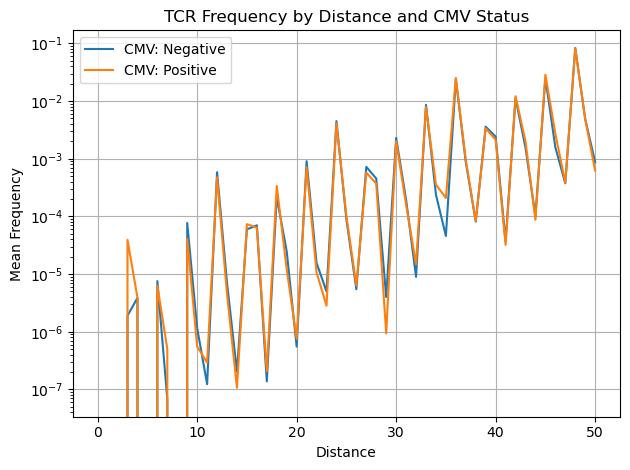

In [33]:
import matplotlib.pyplot as plt

for status, group in avg_long.groupby('cmv_status'):
    plt.plot(group['distance'], group['mean_freq'], label=f'CMV: {status}')

plt.xlabel('Distance')
plt.ylabel('Mean Frequency')
plt.title('TCR Frequency by Distance and CMV Status')
plt.legend()
plt.grid(True)
# y log scale
plt.yscale('log')
plt.tight_layout()
plt.show()
